In [10]:
import sys
import torch
import numpy as np
import torch
import traci
from sumolib import checkBinary
import torch
import sys
import os
from utils import *
import copy
import gym
import random
from Models import GRUModel
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
import torch.nn.functional as F
import pandas as pd
import math

if 'SUMO_HOME' in os.environ:
    print('SUMO_HOME found')
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))

# sumoBinary = checkBinary('sumo-gui')
sumoBinary = checkBinary('sumo')
roadNetwork = "./config/osm.sumocfg"
sumoCmd = [sumoBinary, "-c", roadNetwork, "--start", "--quit-on-end"]
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

SUMO_HOME found
Using device: cuda


In [11]:
class Knowledges:
    def __init__(self):
        self.knowledges = {}
        self.delays = {}
    
    def add_observations(self, vehicles, observed_vehicles):
        for vehicle, visibility in zip(vehicles, observed_vehicles):
            if vehicle not in self.knowledges:
                self.knowledges[vehicle] = []
                self.delays[vehicle] = 0
            self.knowledges[vehicle].append(int(visibility))
            if visibility == 0:
                self.delays[vehicle] += 1
            else:
                self.delays[vehicle] = 0
    
    def merge_knowledges(self, new_knowledges, new_delays):
        prev_missing, prev_delay, _, _ = self.evaluate_knowledge()
        for vehicle, visibility in new_knowledges.items():
            if vehicle not in self.knowledges:
                self.knowledges[vehicle] = copy.deepcopy(visibility)
                self.delays[vehicle] = new_delays[vehicle]
            else:
                for i in range(1, len(self.knowledges[vehicle])+1):
                    if i > len(visibility):
                        break
                    self.knowledges[vehicle][-i] = visibility[-i] | self.knowledges[vehicle][-i]
                self.delays[vehicle] = min(self.delays[vehicle], new_delays[vehicle])
        new_missing, new_delay, _, _ = self.evaluate_knowledge()
        return copy.deepcopy(self.knowledges), copy.deepcopy(self.delays), prev_missing - new_missing, prev_delay - new_delay

    def get_knowledges(self):
        return copy.deepcopy(self.knowledges)
    
    def get_delays(self):
        return copy.deepcopy(self.delays)
    
    def evaluate_knowledge(self, large_delay_threshold=10):
        observed = 0
        delay = 0
        large_delay = 0
        num_vehicles = len(self.knowledges)
        whole_missing = 0
        total = 0
        for vehicle, visibility in self.knowledges.items():
            observed += sum(visibility) 
            total += len(visibility)
            delay += self.delays[vehicle]
            if self.delays[vehicle] >= large_delay_threshold or sum(visibility) <= 3:
                large_delay += 1
            if sum(visibility) == 0:
                whole_missing += len(visibility)
        return 1-(observed / total), delay / num_vehicles, large_delay / num_vehicles, whole_missing / total

class Vehicle:
    def __init__(self):
        self.sent = {}
        self.received = 0

    def step(self):
        self.received = 0
        for vehicle, lag in self.sent.items():
            self.sent[vehicle] += 1
        self.sent = {vehicle: lag for vehicle, lag in self.sent.items() if lag < 10}
    
    def receive(self):
        self.received += 1

    # lag: the time since the last communication with a neighbor
    def select(self, neighbors):
        max_lag = 0
        selected = None
        for neighbor in neighbors:
            if neighbor not in self.sent:
                selected = neighbor
                break
            if self.sent[neighbor] > max_lag:
                max_lag = self.sent[neighbor]
                selected = neighbor
        return selected
    
    def send(self, selected_neighbor):
        self.sent[selected_neighbor] = 0

def connectivity(xs,ys, threshold=800):
    xs = torch.tensor(xs, dtype=torch.float32).view(-1,1)
    ys = torch.tensor(ys, dtype=torch.float32).view(-1,1)
    intervehicle_distances = torch.sqrt((xs - xs.t())**2 + (ys - ys.t())**2)
    if threshold is not None:
        # make the distances 1 if less than the threshold, 0 otherwise
        connectivity = torch.where(intervehicle_distances < threshold, torch.ones_like(intervehicle_distances), torch.zeros_like(intervehicle_distances))
    return connectivity, xs, ys

In [46]:
class Incomplete_Routing_Gym(gym.Env):
    def __init__(self, sumoCmd, model, max_steps=1100, n_nodes=57, max_routing_steps=30, max_n_neighbors=6):
        self.sumoCmd = sumoCmd
        self.step_counter = 0
        self.max_steps = max_steps
        self.n_nodes = n_nodes
        self.start_node = None
        self.end_node = None
        self.current_node = None
        self.node_features = None
        self.adj_matrix = None
        self.edge_index = None
        self.hop_thresh = None
        self.routing_done = False
        self.routing_steps = 0
        self.min_n_hops = None
        self.end_node_indicator = torch.zeros(n_nodes)
        self.max_routing_steps = max_routing_steps
        self.n_hop_matrix = None
        self.neighbors_indicator = None
        self.action_space = None
        self.to_remove_indices = None
        self.prunned_adj_matrix = None
        self.prunned_n_hop_matrix = None
        self.state = None
        self.max_n_neighbors = max_n_neighbors
        self.ids = None
        self.vehicle_knowledges = {}
        self.vehicle_records = {}
        self.GRUModel = model
        self.GRUModel.eval()
        self.trajectory_dict = {}
        self.checkpoints_dict = {}

        self.xs = None
        self.ys = None
        self.start_x = None
        self.start_y = None
        self.end_x = None
        self.end_y = None

        self.total_missing_ratio = 0
        self.total_error = 0
        self.total_num_graphs = 0

        self.delay_distribution = []

        self.total_connected = 0
        self.not_observed_dict = {}
        self.observed_dict = {}
        self.total_observed_error = 0

        self.load_all_trajectory()

    

    def load_all_trajectory(self):
        self.checkpoints_dict = get_planned_path()
        checkpoints = list(self.checkpoints_dict.values())
        checkpoints = torch.tensor(checkpoints).float() / 10
        position_df = pd.read_csv('trajectory_time.csv')
        position_df.set_index('Unnamed: 0', inplace=True)
        position_array = position_df.to_numpy()
        sequence_length = position_df.shape[1] // 2
        tensor_list = []

        for row in position_array:
            reshaped_tensor = torch.tensor(row.reshape(sequence_length, 2))
            tensor_list.append(reshaped_tensor)

        all_trajectories_tensor = torch.stack(tensor_list).float() / 10

        next_checkpoint = torch.zeros_like(all_trajectories_tensor)
        next_next_checkpoint = torch.zeros_like(all_trajectories_tensor)
        checkpoints_pad_1 = F.pad(checkpoints, (0, 0, 1, 0))
        for i in range(all_trajectories_tensor.shape[1]):
            _, min_indices = project_to_nearest(all_trajectories_tensor[:, i], checkpoints)
            next_checkpoint[:, i] = checkpoints_pad_1[range(checkpoints.shape[0]), min_indices+1]
            next_next_checkpoint[:, i] = checkpoints_pad_1[range(checkpoints.shape[0]), min_indices+2]

        all_trajectories_tensor = torch.cat((all_trajectories_tensor, next_checkpoint, next_next_checkpoint), dim=2)

        # convert all_trajectories_tensor to a dictionary, where keys are the vehicle ids
        for i, n in enumerate(position_df.index):
            self.trajectory_dict[str(n)] = all_trajectories_tensor[i]
            self.checkpoints_dict[str(n)] = checkpoints[i]

    def reset(self):
        try:
            traci.close()
        except:
            pass
        traci.start(self.sumoCmd)
        self.step_counter = traci.simulation.getTime()

        while self.step_counter < 400:
            self.simstep_with_sync()


    def node_pruning(self):
        self.prunned_adj_matrix = copy.deepcopy(self.observed_adj_matrix)
        self.prunned_n_hop_matrix = copy.deepcopy(self.observed_n_hop_matrix)
        neighbor_indices = np.where(self.observed_adj_matrix[self.current_node] == 1)[0]
        if len(neighbor_indices) >= self.max_n_neighbors:
            two_hop_neighbours_indices = np.where(self.observed_n_hop_matrix[self.current_node] == 2)[0]
            two_hop_neighbours_mask = (self.observed_n_hop_matrix[self.current_node] == 2).type(torch.int)
            # direct neighbours connectivities with two hop neighbours
            neighbour_dict = {}
            for neighbour_index in neighbor_indices:
                neighbour_dict[neighbour_index] = two_hop_neighbours_indices[np.where(self.observed_adj_matrix[neighbour_index][two_hop_neighbours_indices] == 1)[0]]
            # sort by the number of two hop neighbours
            neighbour_dict = dict(sorted(neighbour_dict.items(), key=lambda item: len(item[1]), reverse=True))

            self.to_remove_indices = []
            action_space = 0
            for neighbour_index, two_hop_neighbours_indices in neighbour_dict.items():
                mask_sum_before = torch.sum(two_hop_neighbours_mask)
                two_hop_neighbours_mask[two_hop_neighbours_indices] = 0
                mask_sum_after = torch.sum(two_hop_neighbours_mask)
                if mask_sum_after < mask_sum_before:
                    action_space += 1
                else:
                    self.to_remove_indices.append(neighbour_index)
            if action_space < self.max_n_neighbors:
                self.to_remove_indices = random.sample(self.to_remove_indices, len(self.to_remove_indices) - (self.max_n_neighbors - action_space))
            self.prunned_adj_matrix[self.to_remove_indices, :] = 0
            self.prunned_adj_matrix[:, self.to_remove_indices] = 0
            self.prunned_n_hop_matrix[self.to_remove_indices, :] = 0
            self.prunned_n_hop_matrix[:, self.to_remove_indices] = 0
        self.prunned_n_hop_matrix = self.prunned_n_hop_matrix - torch.diag(torch.diag(self.prunned_n_hop_matrix))
        self.prunned_adj_matrix = self.prunned_adj_matrix - torch.diag(torch.diag(self.prunned_adj_matrix))


    def next_episode(self):
        self.simstep_with_sync()
        self.current_node = self.start_node
        self.adj_matrix = F.pad(self.adj_matrix, (0, self.n_nodes - self.adj_matrix.size(0), 
                                                  0, self.n_nodes - self.adj_matrix.size(1)), "constant", 0)
        self.n_hop_matrix = F.pad(self.n_hop_matrix, (0, self.n_nodes - self.n_hop_matrix.size(0), 
                                                      0, self.n_nodes - self.n_hop_matrix.size(1)), "constant", -100)
        for i in range(len(self.ids)):
            self.current_node = i
            self.state = self.get_state()

    def simstep_with_sync(self):
        traci.simulationStep()
        self.routing_done = False
        self.routing_steps = 0
        self.step_counter = int(traci.simulation.getTime())
        self.adj_matrix, self.xs, self.ys = intervehicleConnectivity_xs_ys(800)
        self.select_start_end_nodes()
        self.ids = traci.vehicle.getIDList()
        action_spaces = self.adj_matrix - torch.diag(torch.diag(self.adj_matrix))

        for i, vehicle in enumerate(self.ids):
            if vehicle not in self.vehicle_knowledges:
                self.vehicle_knowledges[vehicle] = Knowledges()
            if vehicle not in self.vehicle_records:
                self.vehicle_records[vehicle] = Vehicle()
            self.vehicle_knowledges[vehicle].add_observations(self.ids, self.adj_matrix[i])
        
        for i, vehicle in enumerate(self.ids):
            non_zero_indices = torch.where(action_spaces[i] == 1)[0]
            neighbors = [self.ids[j] for j in non_zero_indices] 
            if len(neighbors) > 0:
                select_neighbour = self.vehicle_records[vehicle].select(neighbors)
                if select_neighbour is None:
                    continue
                self.vehicle_records[vehicle].send(select_neighbour)
                self.vehicle_knowledges[select_neighbour].merge_knowledges(self.vehicle_knowledges[vehicle].get_knowledges(), self.vehicle_knowledges[vehicle].get_delays())

                self.vehicle_records[select_neighbour].send(vehicle)
                self.vehicle_knowledges[vehicle].merge_knowledges(self.vehicle_knowledges[select_neighbour].get_knowledges(), self.vehicle_knowledges[select_neighbour].get_delays())
            
        for vehicle in self.vehicle_records.values():
            vehicle.step()

        
    def select_start_end_nodes(self, refresh=False):
        if not refresh:
            self.n_hop_matrix = bfs_distance(self.adj_matrix)
            self.hop_thresh = min(self.n_hop_matrix.max(), 5)
        starts, ends = torch.where(self.hop_thresh == self.n_hop_matrix)
        starts = starts.tolist()
        ends = ends.tolist()
        self.start_node, self.end_node = random.choice(list(zip(starts, ends)))
        # minimal number of hops between start and end nodes
        self.min_n_hops = self.n_hop_matrix[self.start_node, self.end_node]

        self.start_x = self.xs[self.start_node]
        self.start_y = self.ys[self.start_node]
        self.end_x = self.xs[self.end_node]
        self.end_y = self.ys[self.end_node]
    

    def get_state(self):
        current_vehicle_knowledge = self.vehicle_knowledges[self.ids[self.current_node]].get_knowledges()
        current_vehicle_delay = self.vehicle_knowledges[self.ids[self.current_node]].get_delays()
        observed_vehicle_xs = []
        observed_vehicle_ys = []
        for vehicle in self.ids:
            if current_vehicle_delay[vehicle] == 0:
                observed_vehicle_xs.append(self.xs[self.ids.index(vehicle)])
                observed_vehicle_ys.append(self.ys[self.ids.index(vehicle)])
            elif current_vehicle_delay[vehicle] >= 10 or sum(current_vehicle_knowledge[vehicle]) <= 3:
                observed_vehicle_xs.append(-1)
                observed_vehicle_ys.append(-1)
            else:
                x, y = self.estimate_vehicle_positions(vehicle, current_vehicle_knowledge[vehicle], current_vehicle_delay[vehicle])
                observed_vehicle_xs.append(x)
                observed_vehicle_ys.append(y)
        
        # # get the number of -1s in observed_vehicle_xs and observed_vehicle_ys
        # missing = sum([1 for x, y in zip(observed_vehicle_xs, observed_vehicle_ys) if x == -1 and y == -1])
        # missing_ratio = missing / len(observed_vehicle_xs)
        # # get the error in non-missing values
        # error = 0
        # for i, (x, y) in enumerate(zip(observed_vehicle_xs, observed_vehicle_ys)):
        #     if x == -1 and y == -1:
        #         continue
        #     error += torch.sqrt((x - self.xs[i])**2 + (y - self.ys[i])**2)
        # error /= len(observed_vehicle_xs) - missing
        
        # self.total_missing_ratio += missing_ratio
        # self.total_error += error
        # self.total_num_graphs += 1

        # self.delay_distribution += [current_vehicle_delay[vehicle]]

        observed_adj_matrix, _, _ = connectivity(observed_vehicle_xs, observed_vehicle_ys, 800)
        observed_n_hop_matrix = bfs_distance(observed_adj_matrix)
        observed_current_node_n_hop = observed_n_hop_matrix[self.current_node]
        current_node_n_hop = self.n_hop_matrix[self.current_node]
        for i in range(len(observed_current_node_n_hop)):
            if current_node_n_hop[i] == -100:
                continue
            self.total_connected += 1

            true_distance = int(current_node_n_hop[i])
            if observed_current_node_n_hop[i] == -100:
                if true_distance not in self.not_observed_dict:
                    self.not_observed_dict[true_distance] = 0
                self.not_observed_dict[true_distance] += 1
            else:
                if true_distance not in self.observed_dict:
                    self.observed_dict[true_distance] = 0
                self.observed_dict[true_distance] += 1
                self.total_observed_error += int(torch.abs(observed_current_node_n_hop[i] - current_node_n_hop[i]))

    
    def estimate_vehicle_positions(self, vehicle, observation_history, delay):
        last_seen_time = int(self.step_counter - delay)
        first_one_index = int(observation_history.index(1))
        sequence_length = min(len(observation_history) - first_one_index, 20)
        # these last seen value will be used to calibrate the position of the vehicle
        # we set the last seen value to 50, 50, as the autoregressive model is trained on the normalized values
        last_seen_x = self.trajectory_dict[vehicle][last_seen_time][0].item()
        last_seen_y = self.trajectory_dict[vehicle][last_seen_time][1].item()
        modif = (torch.tensor([last_seen_x, last_seen_y])-torch.tensor([50, 50])).repeat(1, 3)

        masks = torch.tensor(observation_history).unsqueeze(0).unsqueeze(2).repeat(1, 1, 6)

        paths = self.checkpoints_dict[vehicle].unsqueeze(0)
        inputs = copy.deepcopy(self.trajectory_dict[vehicle][self.step_counter-sequence_length+1:self.step_counter+1].unsqueeze(0))
        inputs -= modif
        masks = masks[:, -sequence_length:, :]
        modified_x, modified_y = self.GRU_inference(inputs.to(device), masks.to(device), paths.to(device))
        x, y = (modified_x + modif[0][0]).item() * 10, (modified_y + modif[0][1]).item() * 10
        return x, y
    

    def GRU_inference(self, inputs, masks, paths):
        with torch.no_grad():
            hidden = None
            seq_len = inputs.size(1)
            current_input = inputs[:, 0, :].unsqueeze(1)
            for t in range(1, seq_len):
                prediction, hidden = self.GRUModel(current_input, hidden)
                projection_with_checkpoints = project_to_nearest_with_checkpoints(prediction, paths)
                current_input = (projection_with_checkpoints * (1-masks[:, t, :]) + inputs[:, t, :] * (masks[:, t, :])).unsqueeze(1)
        return current_input[0,0,0], current_input[0,0,1]

    def sim_done(self):
        """
        function: get the done state of simulation.
        """
        return not (shouldContinueSim() and self.step_counter < self.max_steps)


# Test the environment

In [47]:
model = GRUModel(input_size=6, hidden_size=256, num_layers=2, output_size=2).to(device)
# load the model
model.load_state_dict(torch.load('models/gru_trajectory_prediction.pth'))
model.eval()
env = Incomplete_Routing_Gym(sumoCmd, model)
env.reset()
sim_done = False
while not sim_done:
    state = env.next_episode()
    sim_done = env.sim_done()
    print(env.step_counter)

Simulation ended at time: 467.00
Reason: TraCI requested termination.
Performance: 
 Duration: 575.33s
 TraCI-Duration: 321.51s
 Real time factor: 0.811702
 UPS: 19.512144
Vehicles: 
 Inserted: 52 (Loaded: 70)
 Running: 43
 Waiting: 0
Statistics (avg of 9):
 RouteLength: 2349.94
 Speed: 9.93
 Duration: 242.33
 WaitingTime: 7.22
 TimeLoss: 32.38
 DepartDelay: 0.33

 Retrying in 1 seconds
***Starting server on port 43677 ***
Loading net-file from './config/osm.net.xml.gz' ... done (111ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Simulation ended at time: 1557.00
Reason: TraCI requested termination.
Performance: 
 Duration: 0.38s
 TraCI-Duration: 0.24s
 Real time factor: 4108.18
 UPS: 121456.464380
Vehicles: 
 Inserted: 89
 Running: 0
 Waiting: 0
Statistics (avg of 89):
 RouteLength: 4885.02
 Speed: 9.58
 Duration: 517.21
 WaitingTime: 17.72
 TimeLoss: 70.09
 DepartDelay: 0.47

 Retrying in 1 seconds
***Starting server on port 60571 ***
Loading net-file from './co

In [48]:
print("Not observed distribution: ", env.not_observed_dict)
print("Observed distribution: ", env.observed_dict)
print("Average observed error: ", env.total_observed_error / env.total_connected)
total_observed = sum(env.observed_dict.values())
total_not_observed = sum(env.not_observed_dict.values())
assert total_observed + total_not_observed == env.total_connected
print("Total observed ratio: ", total_observed / env.total_connected)

Not observed distribution:  {4: 13263, 5: 15847, 3: 8671, 2: 2649, 6: 14710, 7: 12761, 8: 9944, 9: 7201, 10: 4076, 11: 2113, 12: 1105, 13: 527, 16: 12, 14: 212, 15: 38, 17: 4}
Observed distribution:  {1: 128456, 2: 114423, 3: 88663, 4: 62313, 5: 43179, 6: 28886, 7: 20081, 8: 11996, 9: 6323, 10: 2688, 11: 1059, 12: 365, 13: 87, 14: 20}
Average observed error:  0.21677924184605565
Total observed ratio:  0.8452096823518462


In [16]:
print("Average missing ratio: ", env.total_missing_ratio / env.total_num_graphs)
print("Average error: ", env.total_error / env.total_num_graphs)

Average missing ratio:  0.5174758602064191
Average error:  tensor([126.1921])


(array([26328.,  2739.,  1350.,   684.,   458.,   276.,   165.,   123.,
          113.,    56.]),
 array([  0. ,  19.3,  38.6,  57.9,  77.2,  96.5, 115.8, 135.1, 154.4,
        173.7, 193. ]),
 <BarContainer object of 10 artists>)

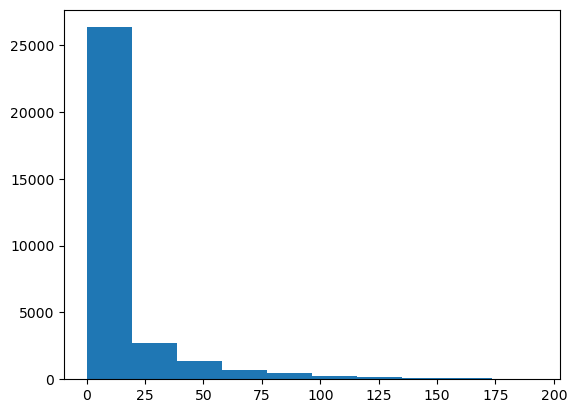

In [21]:
# plot the delay distribution
import matplotlib.pyplot as plt
# lod the delay distribution
delay_distribution = np.load('delay_distribution.npy')
plt.hist(delay_distribution, bins=10)

Not observed distribution:  {4: 871, 5: 761, 3: 794, 2: 283, 6: 460, 7: 352, 8: 215, 9: 81, 10: 14}
Observed distribution:  {1: 7469, 2: 5889, 3: 4681, 4: 2979, 5: 2053, 6: 1029, 7: 514, 8: 285, 9: 87, 10: 8}
Average observed error:  0.14289679098005204
Total observed ratio:  0.8670945359930616
